In [1]:
from google.cloud import storage
import gcsfs
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from PIL import Image
from src.utils.gcs_utils import *
from pathlib import Path
import json
import cv2
import io
import numpy as np
import pickle
import yaml
import pandas as pd
import os
import torch


The purpose of this notebook is to understand how to read and save to the google bucket.

# 1. Read from Google Cloud

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'path to auth.json file'

## 1.1 Read images 

In [3]:
bucket = get_bucket_gcs('oro-ds-test-bucket')
images,labels = read_images_gcs(bucket, prefix='shanel_test/data_4class_skin_diseases/')

In [4]:
df = pd.read_csv('gs://oro-ds-test-bucket/shanel_test/raw_image_paths_from_db.csv')
df = df.to_csv(encoding="utf-8")

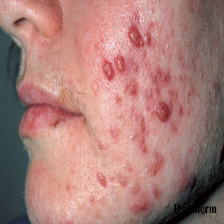

In [5]:
image = image_reader(bucket, images[20])
Image.fromarray(image)

## 1.2 Read CSV file

In [6]:
df = pd.read_csv('gs://oro-ds-test-bucket/shanel_test/raw_image_paths_from_db.csv')
df.head(5)

,Unnamed: 0,pathBucketImage,labelledby,reviewedby,acne_comedos,acne_cystic,acne_mixed,acne_scars,acne_excoriated,rosacea_erythemato_telangiectasique,...,keratosis_pilaris,molluscum,folliculitis,melanonychia,nevus,lichen_planus,chelitis_actinic,cheilitis_eczematous,urticaria,unspecified
0,0,7830/646B3FD8EE/ailment_photos/AP-c1bbfaeb-178...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,9369/005F4BC9BC/ailment_photos/AP-231d589b-377...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2,936/E617F7DF5F/ailment_photos/AP-cc6f0aa7-75a6...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,9716/7C41A121CF/ailment_photos/AP-5643b306-19d...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,4,9718/BF893BCA47/ailment_photos/AP-0743efe6-50a...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## 1.3 Read pickle file

In [7]:
blob = bucket.blob('shanel_test/filename.pickle')
pickle_in = blob.download_as_string()
my_dictionary = pickle.loads(pickle_in)
my_dictionary

{0: 'acne', 1: 'eczema_craquelee', 2: 'herpes simplex', 3: 'urticaria'}

## 1.4 Read json file

In [8]:
blob = bucket.blob('shanel_test/class_names.json')
pickle_in = blob.download_as_string()
my_dictionary= json.loads(blob.download_as_string(client=None))
my_dictionary

{'0': 'acne', '1': 'eczema_craquelee', '2': 'herpes simplex', '3': 'urticaria'}

## 1.5 Read Torch State Dictionary

In [9]:
blob = bucket.blob('shanel_test/bit.pth')
blob._chunk_size = 8388608  # 1024 * 1024 B * 16 = 8 MB
blob.download_to_filename('bit.pth')

## 1.6 Read YAML file



In [10]:
blob = bucket.blob('shanel_test/conf/parameters.yml')
my_dictionary= yaml.safe_load(blob.download_as_string(client=None))
my_dictionary

{'model': {'cnn': {'random_state': 42,
   'batch_size': 16,
   'num_epochs': 26,
   'lr': 0.0001,
   'gpu_to_use': 0},
  'bit': {'random_state': 42,
   'batch_size': 16,
   'num_epochs': 18,
   'lr': 0.0006,
   'gpu_to_use': 1}},
 'dataset': {'height': 224, 'width': 224}}

# 2. Save into Google Cloud

## 2.1 Save an image

In [11]:
path2 = 'resized/image.JPEG'

'shanel_test/'+path2

'shanel_test/resized/image.JPEG'

In [12]:
img_byte_array = io.BytesIO()
Image.fromarray(image).save(img_byte_array, format='JPEG')
# Create the propper blob using the same bucket and upload it with it's content type
path2 = 'resized/image.JPEG'
blob = bucket.blob('shanel_test/'+path2)
blob.upload_from_string(img_byte_array.getvalue(), content_type="image/jpeg")

## 2.2 Save CSV file

In [13]:
df = pd.read_csv('gs://oro-ds-test-bucket/shanel_test/raw_image_paths_from_db.csv')
df_csv_data= df.to_csv(encoding="utf-8")
bucket.blob('shanel_test/projet/train_set_initial.csv').upload_from_string(df_csv_data,content_type='text/csv')

## 2.3 Save Pickle file

In [14]:
bucket.blob('shanel_test/test_pickle.pickle').upload_from_string(data=pickle.dumps(my_dictionary))

## 2.4 Save Json file


In [15]:
bucket.blob('shanel_test/train_set_initial.json').upload_from_string(data=json.dumps(my_dictionary), 
                                                                    content_type='application/json')

## 2.5 Save Model Dictionary

In [16]:
blob = bucket.blob('shanel_test/bit.pth')
blob._chunk_size = 8388608  # 1024 * 1024 B * 16 = 8 MB
blob.upload_from_filename('bit.pth')



In [17]:
# remove downloaded file
os.remove('bit.pth')